<a href="https://colab.research.google.com/github/erictong0/FrederickLab2023/blob/main/Subtraction/INADEQUATE/230709_Not_GLY_subtraction_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bio --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 119.7 MB/s eta 0:00:00


In [ ]:
from posixpath import join
import sys
import glob
import math
import pandas as pd
import argparse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker
import scipy as sp
import csv
import re
import traceback
from matplotlib import colors
import matplotlib.cm as cm
from statistics import mean
from Bio.Data.IUPACData import protein_letters_1to3 as one2three
from numpy import savetxt
from seaborn.widgets import color_palette

In [ ]:
aaName = "THR"
aaLetter = "T"

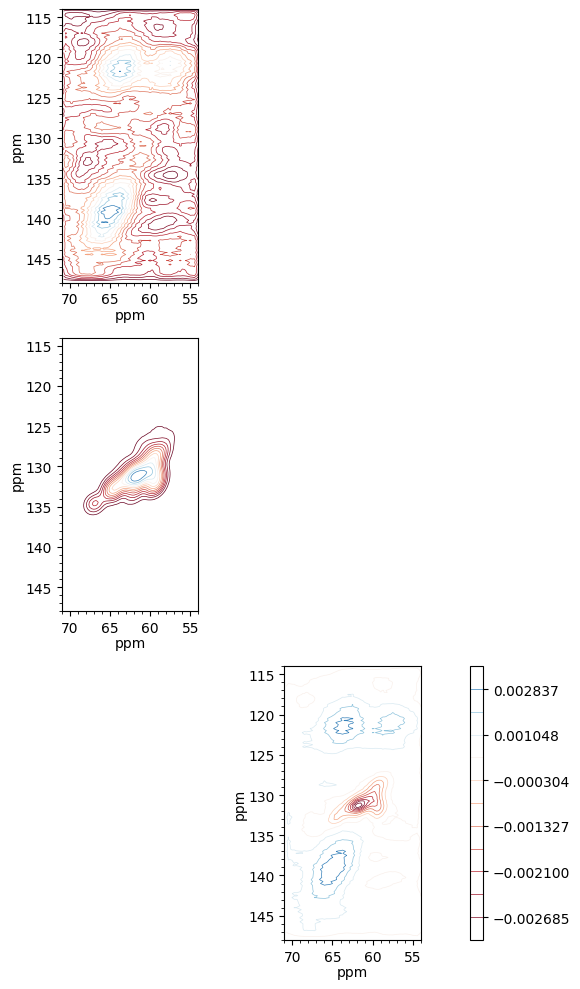

In [ ]:
def main(PDB_file, exp_file, output_file_path, aa):
  aa1 = aa
  data = []
  with open(PDB_file, mode="r") as infile: #open data file and read contents
    reader = csv.reader(infile, delimiter="\n")
    for row in reader:
      if len(row) == 1:
        data.append(re.split(r'\t', row[0])[2:])
      else:
        data.append(row)

  def get_row_floats(data, row):
    return list(map(lambda x: float(x[row]), data))

  phi = get_row_floats(data[1:], 0)
  psi = get_row_floats(data[1:], 1)
  x = get_row_floats(data[1:], 2)
  y = get_row_floats(data[1:], 3) ###Might change in future
  z = get_row_floats(data[1:], 4)
  w = get_row_floats(data[1:], 5)

  j = []
  for i in range(len(x)):
    j.append(x[i] + y[i])

  #j = y ###Might change in future?
  data = []
  count = 0

  with open(exp_file, mode="r") as infile: #open data file and read contents
    reader = csv.reader(infile, delimiter="\n")
    #print(infile.readlines())
    for row in reader:
      if len(row) == 1:
        data.append(re.split(r'\s+', row[0])[1:])
      else:
        data.append(row)

  ca_exp=[]
  inadequate=[]
  cb_exp=[]
  intensity=[]
  for i in range(len(data)):
    ca_exp.append(float(data[i-1][0])) #def x as Ca shift
    inadequate.append(float(data[i-1][1]))
    cb_exp.append(float(data[i-1][1])) #def y as Cb shift
    intensity.append(float(data[i-1][2]))

  for i in range(len(inadequate)):
    inadequate[i-1] = inadequate[i-1]-1
  min = np.min(intensity)
  for i in range(len(intensity)):
    intensity[i-1] = intensity[i-1]-min

  mask = np.logical_and(np.array(inadequate) >= 29, np.array(inadequate) <= 37)
  mask = np.logical_and(mask, np.array(ca_exp) >= 54)
  mask = np.logical_and(mask, np.array(ca_exp) <= 71)

  atom_key={
            "ca":0,
            "cb":1,
            "co":2,
            "n":3,
          }
  nonCys_nonGly_aas={"A", "D", "E", "F", "H", "I", "K", "L", "M",
                    "N", "P", "Q", "R", "S", "T", "V", "Y", "W"}
  nonCys_aas={"A", "D", "E", "F", "G", "H", "I", "K", "L", "M",
              "N", "P", "Q", "R", "S", "T", "V", "Y", "W"}
  na=np.nan
  aa_spec_ranges={ #ranges of interest for chemical shifts
                  #aa1 Ca      Cb      C         N
                  # Ca & Cb adjusted to 17ppm to match Fig5
                  'A':[[44,61],[55,89],[170,184],[112,133]],
                  'R':[[47,64],[22,39],[169,183],[112,133]],
                  'N':[[44,61],[30,47],[168,182],[106,127]],
                  'D':[[45,62],[33,50],[169,183],[109,130]],
  #               'C':[[50,67],[22,39],[168,182],[105,126]],
                  'Q':[[47,64],[22,39],[169,183],[108,129]],
                  'E':[[49,66],[22,39],[169,183],[109,130]],
                  'G':[[36,53],[203,234],[167,181],[ 98,119]],
                  'H':[[49,66],[23,40],[168,182],[107,128]],
                  'I':[[54,71],[31,48],[168,182],[109,130]],
                  'L':[[45,62],[33,50],[170,184],[110,131]],
                  'K':[[49,66],[26,43],[169,183],[109,130]],
                  'M':[[47,64],[26,43],[169,183],[108,129]],
                  'F':[[50,67],[31,48],[168,182],[107,128]],
                  'P':[[57,74],[25,42],[170,184],[ na, na]],
                  'S':[[50,67],[105,139],[55,72],[167,181],[104,125]],
                  'T':[[54,71],[114,148],[60,77],[168,182],[102,123]],
                  'W':[[48,65],[21,38],[169,183],[109,130]],
                  'Y':[[50,67],[30,47],[168,182],[108,129]],
                  'V':[[54,71],[25,42],[169,183],[108,129]],
                  }
  aa_atom_groups={
                  'A':[['co','ca'],['ca','cb']],
  #               'C':[['co','ca'],['ca','cb']],
                  'D':[['co','ca'],['ca','cb']],
                  'E':[['co','ca'],['ca','cb']],
                  'F':[['co','ca'],['ca','cb']],
                  'G':[['co','ca']],
                  'H':[['co','ca'],['ca','cb']],
                  'I':[['co','ca'],['ca','cb']],
                  'K':[['co','ca'],['ca','cb']],
                  'L':[['co','ca'],['ca','cb']],
                  'M':[['co','ca'],['ca','cb']],
                  'N':[['co','ca'],['ca','cb']],
                  'P':[['co','ca'],['ca','cb']],
                  'Q':[['co','ca'],['ca','cb']],
                  'R':[['co','ca'],['ca','cb']],
                  'S':[['co','ca'],['ca','cb']],
                  'T':[['co','ca'],['ca','cb']],
                  'V':[['co','ca'],['ca','cb']],
                  'Y':[['co','ca'],['ca','cb']],
                  'W':[['co','ca'],['ca','cb']],
                }
  atom_a = "ca" #defining atom_a as the alpha carbon
  atom_b = "cb" #defining atom_b as the beta carbon
  aaX = aa1 #define aaX as residue of interest (one letter code)
  points = zip(atom_a, atom_b) #create an array with both atom_a and atom_b

  aaX = aa
  subplot_counter = 0
  aaX = aa1
  atom_a = atom_a.lower(); atom_b = atom_b.lower()#

  CAs=[]; CBs=[]; COs=[]; Ns=[]

  # join CS of each atom into one list #
  if aa1 in nonCys_nonGly_aas:
          all_CS = [x, y, y, z]
  elif aa1 == 'G':
          all_CS = [x, j, y, w] ###Relevant?
  elif aa1 == 'C':
          print('Skipping cysteine since PPM has no prediction for Cys.')
  else:
          print('Error: amino acid \"{}\" not implemented'.format(aa1))
          sys.exit()

  x_key=atom_key[atom_a]
  y_key=atom_key[atom_b]
  bin_width=0.25
  mtick_spacing=5
  x_lims = np.array(aa_spec_ranges[aa1])
  y_lims = np.array(aa_spec_ranges[aa1][1])
  x_edges = np.arange(x_lims[0][0],x_lims[0][1]+bin_width,bin_width) #create an array from one limit to the next using bin widths
  y_edges=np.arange(y_lims[0],y_lims[1]+bin_width,bin_width)
  hw=bin_width/2
  center_bins_x=np.arange(x_lims[0][0]+hw,x_lims[0][1]+hw,bin_width)
  center_bins_y=np.arange(y_lims[0]+hw,y_lims[1]+hw,bin_width)

  # calculate counts for bins #
  H1, npxedges, npyedges = np.histogram2d(j, x,
                                          bins=(y_edges,x_edges))#, weights = [w[i]]*len(all_CS[y_key]),)

  H = H1
  h_lists = []
  h = []

  fwhm = 1.5  # Full width at half maximum
  def gaussian2d(x, y, amplitude, xo, yo, fwhm):
    d = fwhm / (2 * np.sqrt(2 * np.log(2)))
    h_list = [0]*len(H)
    xgrid, ygrid = np.meshgrid(x, y)
    g = np.zeros_like(xgrid)
    for i in range(len(xo)-1):
        for j in range(len(yo)-1):
            a = 1/(2*d**2)
            c = 1/(2*d**2)
            xi = np.linspace(xo[i] - 3 * d, xo[i] + 3 * d, len(xo))
            yi = np.linspace(yo[j] - 3 * d, yo[j] + 3 * d, len(yo))
            xigrid, yigrid = np.meshgrid(xi, yi)
            gi = amplitude[i][j]*np.exp( - (a*((xigrid-xo[i])**2) + a*((yigrid-yo[j])**2)))
            H3, npxedges1, npyedges1 = np.histogram2d(yigrid.ravel(),xigrid.ravel(),bins=(npyedges,npxedges),weights = gi.ravel())
            h_list.append(H3)
            H3, npxedges1, npyedges1 = np.histogram2d(yigrid.ravel(),xigrid.ravel(),bins=(npyedges,npxedges),weights = gi.ravel())
            h_list.append(H3)
    h_lists.append(sum(h_list))
    h = sum(h_lists)
    return(h)

  Z = gaussian2d(npxedges[:-1], npyedges[:-1], H, npxedges[:-1], npyedges[:-1], fwhm)


  ### Adjusting the spectra measured for the experimental
  adjDist = 0
  new_x_edges = np.arange(x_lims[0][0] - adjDist, x_lims[0][1] - adjDist + bin_width,bin_width)
  #x_edges = np.arange(x_lims[0][0], x_lims[0][1] + bin_width,bin_width)
  new_y_edges=np.arange(y_lims[0] - adjDist * 2 ,y_lims[1] - adjDist * 2 + bin_width,bin_width)
  ###




  H_exp, npxedges_exp, npyedges_exp = np.histogram2d(inadequate, ca_exp, bins=(new_y_edges, new_x_edges), weights=intensity)
  h = Z
  c=[]
  d =[]
  for i in range(len(h)):
    c = h[i-1]/sum(sum(h))
    d.append(c)
  H=np.array(d).T
  c=[]
  d =[]
  h_exp = H_exp
  np.set_printoptions(threshold=np.inf)
  #####################################################################
  H_exp = sp.ndimage.uniform_filter(H_exp, size=4, mode='constant')

  ###Change this for varying heights for each graph
  H_exp_max = max([max(array) for array in H_exp])
  H_max = max([max(array) for array in H])
  for i in range(len(H_exp)):
    #c = (H_exp[i-1])/sum(sum(H_exp))
    c = (H_exp[i-1]) * H_max / H_exp_max
    #c = (H_exp[i-1]*0.007033550868176652)/(sum(sum(h_exp))*0.0022451602109917292 )
    d.append(c)
  #####################################################################

  H_exp=np.array(d)
  H_exp_max = max([max(array) for array in H_exp])

  def index_2d(myList, v):
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

  #print(f"{np.where(H_exp == H_exp_max)}, {np.where(H == H_max)}")
  ###subtraction###
  h = np.subtract(H_exp,H)
  savetxt(f'urea - {aaName}',h,delimiter=',')
  max_cont = np.max(H)

  #ensemble_size = len(all_CS[y_key])
  #factor size of 1.15
  #13steps

  min_cont = np.min(H) # ensemble_size/2000*(5units*bin_width)
  step = []
  for i in range(13):
    x = 1.15**i
    step.append(x)
  steps = sum(step)
  step_cont = np.subtract(max_cont,min_cont)/steps
  array = np.zeros(13)

  for i in range(13):
    if i == 0:
      array[i] = (((1.15 ** i) * (step_cont))) + min_cont
    else:
      array[i] = (((1.15 ** i) * (step_cont))) + array[i-1]

  levels = array
  min_cont = np.min(h) # ensemble_size/2000*(5units*bin_width)
  max_cont = np.max(h) ###Controls the contour lines

  step = []
  for i in range(13):
    x = 1.15**i
    step.append(x)
  steps = sum(step)
  step_cont = np.subtract(max_cont,min_cont)/steps
  array = np.zeros(13)

  for i in range(13):
    if i == 0:
      array[i] = (((1.15 ** i) * (step_cont))) + min_cont
    else:
      array[i] = (((1.15 ** i) * (step_cont))) + array[i-1]
  levels2 = array

  subplot_counter = 0
        # draw the subplot #
  fig, axs = plt.subplots(3, figsize=(10,10), tight_layout=True)

  a = axs[0].contour(x_edges[:-1], y_edges[:-1], H_exp, levels = levels, cmap='RdBu',linewidths=0.5)
  b = axs[1].contour(x_edges[:-1], y_edges[:-1], H, levels = levels, cmap='RdBu',linewidths=0.5)

  min_cont = np.min(H) # ensemble_size/2000*(5units*bin_width)
  max_cont = np.max(H) ###Controls the contour lines

  c = axs[2].contour(x_edges[:-1], y_edges[:-1], h, levels = levels2, cmap='RdBu',linewidths=0.5)

  for n in range(3):
    axs[n].set_aspect('equal')
    axs[n].set_xlim(x_lims[0][0],aa_spec_ranges[aa1][0][1])
    axs[n].set_ylim(y_lims[0],y_lims[1])
    #axs[n].set_xlim(48, 58)
    #axs[n].set_ylim(65, 75)
    axs[n].xaxis.set_major_locator(pltticker.MultipleLocator(mtick_spacing))
    axs[n].yaxis.set_major_locator(pltticker.MultipleLocator(mtick_spacing))
    axs[n].xaxis.set_minor_locator(pltticker.MultipleLocator(1))
    axs[n].yaxis.set_minor_locator(pltticker.MultipleLocator(1))
    axs[n].set_xlabel('ppm', labelpad=1.0)
    axs[n].set_ylabel('ppm', labelpad=1.0)
    axs[n].invert_xaxis()
    axs[n].invert_yaxis()

  cbar = plt.colorbar(c)
  #cbar2 = plt.colorbar(b)
  ###Change this eventually
  plt.savefig(f"230710_{aaName}_Urea.svg", format='svg')

inputs = f"{aaLetter}_10K.out,230703_{aaName}_INADEQUATE_8M_Urea.txt,out,{aaLetter}".split(",")
PDB_file = inputs[0]
exp_file = inputs[1]
output_file_path = inputs[2]
aa = inputs[3]
main(PDB_file, exp_file, output_file_path, aa)

plt.show()

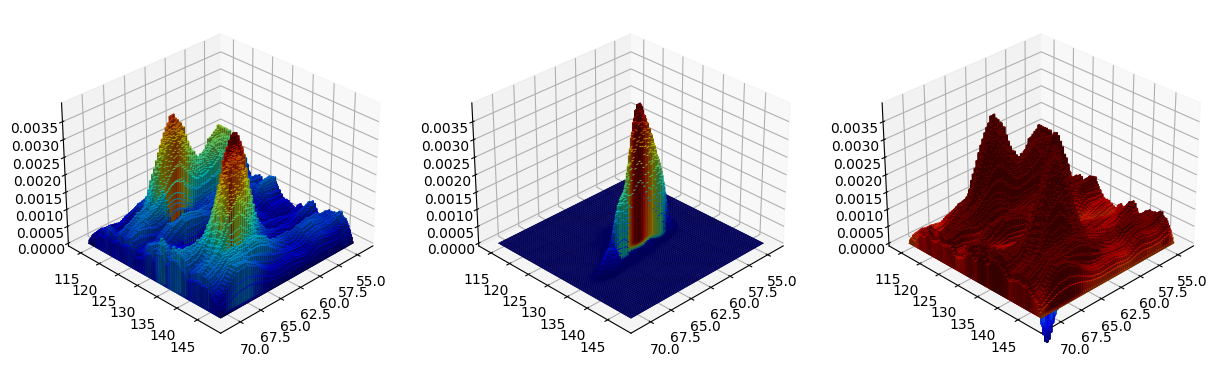

In [ ]:
def main(PDB_file, exp_file, output_file_path, aa):
  aa1 = aa
  data = []
  with open(PDB_file, mode="r") as infile: #open data file and read contents
    reader = csv.reader(infile, delimiter="\n")
    for row in reader:
      if len(row) == 1:
        data.append(re.split(r'\t', row[0])[2:])
      else:
        data.append(row)

  def get_row_floats(data, row):
    return list(map(lambda x: float(x[row]), data))

  phi = get_row_floats(data[1:], 0)
  psi = get_row_floats(data[1:], 1)
  x = get_row_floats(data[1:], 2)
  y = get_row_floats(data[1:], 3)
  z = get_row_floats(data[1:], 4)
  w = get_row_floats(data[1:], 5)

  j = []
  for i in range(len(x)):
    j.append(x[i] + y[i])

  data = []
  count = 0

  with open(exp_file, mode="r") as infile: #open data file and read contents
    reader = csv.reader(infile, delimiter="\n")
    #print(infile.readlines())
    for row in reader:
      if len(row) == 1:
        data.append(re.split(r'\s+', row[0])[1:])
      else:
        data.append(row)

  ca_exp=[]
  inadequate=[]
  cb_exp=[]
  intensity=[]
  for i in range(len(data)):
    ca_exp.append(float(data[i-1][0])) #def x as Ca shift
    inadequate.append(float(data[i-1][1]))
    cb_exp.append(float(data[i-1][1])) #def y as Cb shift
    intensity.append(float(data[i-1][2]))

  for i in range(len(inadequate)):
    inadequate[i-1] = inadequate[i-1]-1
  min = np.min(intensity)
  for i in range(len(intensity)):
    intensity[i-1] = intensity[i-1]-min

  mask = np.logical_and(np.array(inadequate) >= 29, np.array(inadequate) <= 37)
  mask = np.logical_and(mask, np.array(ca_exp) >= 54)
  mask = np.logical_and(mask, np.array(ca_exp) <= 71)

  atom_key={
            "ca":0,
            "cb":1,
            "co":2,
            "n":3,
          }
  nonCys_nonGly_aas={"A", "D", "E", "F", "H", "I", "K", "L", "M",
                    "N", "P", "Q", "R", "S", "T", "V", "Y", "W"}
  nonCys_aas={"A", "D", "E", "F", "G", "H", "I", "K", "L", "M",
              "N", "P", "Q", "R", "S", "T", "V", "Y", "W"}
  na=np.nan
  aa_spec_ranges={ #ranges of interest for chemical shifts
                  #aa1 Ca      Cb      C         N
                  # Ca & Cb adjusted to 17ppm to match Fig5
                  #'A':[[44,61],[55,89],[170,184],[112,133]],
                  'A':[[48,58],[67,77],[170,184],[112,133]],
                  'R':[[47,64],[22,39],[169,183],[112,133]],
                  'N':[[44,61],[30,47],[168,182],[106,127]],
                  'D':[[45,62],[33,50],[169,183],[109,130]],
  #               'C':[[50,67],[22,39],[168,182],[105,126]],
                  'Q':[[47,64],[22,39],[169,183],[108,129]],
                  'E':[[49,66],[22,39],[169,183],[109,130]],
                  'G':[[36,53],[203,234],[167,181],[ 98,119]],
                  'H':[[49,66],[23,40],[168,182],[107,128]],
                  'I':[[54,71],[31,48],[168,182],[109,130]],
                  'L':[[45,62],[33,50],[170,184],[110,131]],
                  'K':[[49,66],[26,43],[169,183],[109,130]],
                  'M':[[47,64],[26,43],[169,183],[108,129]],
                  'F':[[50,67],[31,48],[168,182],[107,128]],
                  'P':[[57,74],[25,42],[170,184],[ na, na]],
                  #'S':[[50,67],[105,139],[55,72],[167,181],[104,125]],
                  'S':[[56,66],[118,128],[55,72],[167,181],[104,125]],
                  'T':[[54,71],[114,148],[60,77],[168,182],[102,123]],
                  'W':[[48,65],[21,38],[169,183],[109,130]],
                  'Y':[[50,67],[30,47],[168,182],[108,129]],
                  'V':[[54,71],[25,42],[169,183],[108,129]],
                  }
  aa_atom_groups={
                  'A':[['co','ca'],['ca','cb']],
  #               'C':[['co','ca'],['ca','cb']],
                  'D':[['co','ca'],['ca','cb']],
                  'E':[['co','ca'],['ca','cb']],
                  'F':[['co','ca'],['ca','cb']],
                  'G':[['co','ca']],
                  'H':[['co','ca'],['ca','cb']],
                  'I':[['co','ca'],['ca','cb']],
                  'K':[['co','ca'],['ca','cb']],
                  'L':[['co','ca'],['ca','cb']],
                  'M':[['co','ca'],['ca','cb']],
                  'N':[['co','ca'],['ca','cb']],
                  'P':[['co','ca'],['ca','cb']],
                  'Q':[['co','ca'],['ca','cb']],
                  'R':[['co','ca'],['ca','cb']],
                  'S':[['co','ca'],['ca','cb']],
                  'T':[['co','ca'],['ca','cb']],
                  'V':[['co','ca'],['ca','cb']],
                  'Y':[['co','ca'],['ca','cb']],
                  'W':[['co','ca'],['ca','cb']],
                }
  atom_a = "ca" #defining atom_a as the alpha carbon
  atom_b = "cb" #defining atom_b as the beta carbon
  aaX = aa1 #define aaX as residue of interest (one letter code)
  points = zip(atom_a, atom_b) #create an array with both atom_a and atom_b

  aaX = aa
  subplot_counter = 0
  aaX = aa1
  atom_a = atom_a.lower(); atom_b = atom_b.lower()#

  CAs=[]; CBs=[]; COs=[]; Ns=[]

  # join CS of each atom into one list #
  if aa1 in nonCys_nonGly_aas:
          all_CS = [x, y, y, z]
  elif aa1 == 'G':
          all_CS = [x, j, y, w]
  elif aa1 == 'C':
          print('Skipping cysteine since PPM has no prediction for Cys.')
  else:
          print('Error: amino acid \"{}\" not implemented'.format(aa1))
          sys.exit()

  x_key=atom_key[atom_a]
  y_key=atom_key[atom_b]
  bin_width=0.25
  mtick_spacing=5
  x_lims = np.array(aa_spec_ranges[aa1])
  y_lims = np.array(aa_spec_ranges[aa1][1])
  x_edges = np.arange(x_lims[0][0],x_lims[0][1]+bin_width,bin_width) #create an array from one limit to the next using bin widths
  y_edges=np.arange(y_lims[0],y_lims[1]+bin_width,bin_width)
  hw=bin_width/2
  center_bins_x=np.arange(x_lims[0][0]+hw,x_lims[0][1]+hw,bin_width)
  center_bins_y=np.arange(y_lims[0]+hw,y_lims[1]+hw,bin_width)

  # calculate counts for bins #
  H1, npxedges, npyedges = np.histogram2d(j, x,
                                          bins=(y_edges,x_edges))#, weights = [w[i]]*len(all_CS[y_key]),)
  H = H1
  h_lists = []
  h = []

  fwhm = 1.5  # Full width at half maximum
  def gaussian2d(x, y, amplitude, xo, yo, fwhm):
    d = fwhm / (2 * np.sqrt(2 * np.log(2)))
    h_list = [0]*len(H)
    xgrid, ygrid = np.meshgrid(x, y)
    g = np.zeros_like(xgrid)
    for i in range(len(xo)-1):
        for j in range(len(yo)-1):
            a = 1/(2*d**2)
            c = 1/(2*d**2)
            xi = np.linspace(xo[i] - 3 * d, xo[i] + 3 * d, len(xo))
            yi = np.linspace(yo[j] - 3 * d, yo[j] + 3 * d, len(yo))
            xigrid, yigrid = np.meshgrid(xi, yi)
            gi = amplitude[i][j]*np.exp( - (a*((xigrid-xo[i])**2) + a*((yigrid-yo[j])**2)))
            H3, npxedges1, npyedges1 = np.histogram2d(yigrid.ravel(),xigrid.ravel(),bins=(npyedges,npxedges),weights = gi.ravel())
            h_list.append(H3)
            H3, npxedges1, npyedges1 = np.histogram2d(yigrid.ravel(),xigrid.ravel(),bins=(npyedges,npxedges),weights = gi.ravel())
            h_list.append(H3)
    h_lists.append(sum(h_list))
    h = sum(h_lists)
    return(h)

  Z = gaussian2d(npxedges[:-1], npyedges[:-1], H, npxedges[:-1], npyedges[:-1], fwhm)




  ### Adjusting the spectra measured for the experimental
  adjDistX = 0
  adjDistY = 2
  adjDistY /= 2
  new_x_edges = np.arange(x_lims[0][0] - adjDistX, x_lims[0][1] - adjDistX + bin_width,bin_width)
  #x_edges = np.arange(x_lims[0][0], x_lims[0][1] + bin_width,bin_width)
  new_y_edges=np.arange(y_lims[0] - adjDistY * 2 ,y_lims[1] - adjDistY * 2 + bin_width,bin_width)
  ###

  ### Adjusting the spectra measured for the experimental
  adjDist = 0
  new_x_edges = np.arange(x_lims[0][0] - adjDist, x_lims[0][1] - adjDist + bin_width,bin_width)
  #x_edges = np.arange(x_lims[0][0], x_lims[0][1] + bin_width,bin_width)
  new_y_edges=np.arange(y_lims[0] - adjDist * 2 ,y_lims[1] - adjDist * 2 + bin_width,bin_width)
  ###


  H_exp, npxedges_exp, npyedges_exp = np.histogram2d(inadequate, ca_exp, bins=(new_y_edges, new_x_edges), weights=intensity)
  h = Z
  c=[]
  d =[]
  for i in range(len(h)):
    c = h[i-1]/sum(sum(h))
    d.append(c)
  H=np.array(d).T
  c=[]
  d =[]
  h_exp = H_exp
  np.set_printoptions(threshold=np.inf)
  #####################################################################
  ###Change this for varying heights for each graph
  H_exp = sp.ndimage.uniform_filter(H_exp, size=4, mode='constant')
  H_exp_max = max([max(array) for array in H_exp])
  H_max = max([max(array) for array in H])
  for j in range(len(H_exp)):
    #c = (H_exp[i-1])/sum(sum(H_exp))
    c = (H_exp[j-1]) * H_max / H_exp_max
    #c = (H_exp[i-1]*0.007033550868176652)/(sum(sum(h_exp))*0.0022451602109917292 )
    d.append(c)
  H_exp=np.array(d)
  #####################################################################




  def index_2d(myList, v):
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

  #print(f"{np.where(H_exp == H_exp_max)}, {np.where(H == H_max)}")
  ###subtraction###
  h = np.subtract(H_exp,H)

  #savetxt(f'urea - {aaName}',h,delimiter=',')
  max_cont = np.max(H)

  #ensemble_size = len(all_CS[y_key])
  #factor size of 1.15
  #13steps

  min_cont = np.min(H) # ensemble_size/2000*(5units*bin_width)
  step = []
  for i in range(13):
    x = 1.15**i
    step.append(x)
  steps = sum(step)
  step_cont = np.subtract(max_cont,min_cont)/steps
  array = np.zeros(13)

  for i in range(13):
    if i == 0:
      array[i] = (((1.15 ** i) * (step_cont))) + min_cont
    else:
      array[i] = (((1.15 ** i) * (step_cont))) + array[i-1]

  levels = array

  #######################################
  min_cont = np.min(h) # ensemble_size/2000*(5units*bin_width)
  max_cont = np.max(h) ###Controls the contour lines

  step = []
  for i in range(13):
    x = 1.15**i
    step.append(x)
  steps = sum(step)
  step_cont = np.subtract(max_cont,min_cont)/steps
  array = np.zeros(13)

  for i in range(13):
    if i == 0:
      array[i] = (((1.15 ** i) * (step_cont))) + min_cont
    else:
      array[i] = (((1.15 ** i) * (step_cont))) + array[i-1]
  levels2 = array
  #######################################

  subplot_counter = 0
        # draw the subplot #
  fig = plt.figure(figsize = (15, 5))
  ax1 = fig.add_subplot(131, projection='3d')
  ax2 = fig.add_subplot(132, projection = '3d')
  ax3 = fig.add_subplot(133, projection = '3d')
  AXS = [ax1, ax2, ax3]
  HS = [H_exp, H, h]


  xedges = new_x_edges
  yedges = new_y_edges

  xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

  xpos = xpos.flatten()/2.
  ypos = ypos.flatten()/2.
  zpos = np.zeros_like(xpos)

  dx = xedges [1] - xedges [0]
  dy = yedges [1] - yedges [0]

  for i in range(len(HS)):
    dz = HS[i].flatten()
    cmap = cm.jet # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz]

    AXS[i].bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    AXS[i].view_init(elev=30, azim=45)

inputs = f"{aaLetter}_10K.out,230703_{aaName}_INADEQUATE_8M_Urea.txt,out,{aaLetter}".split(",")
PDB_file = inputs[0]
exp_file = inputs[1]
output_file_path = inputs[2]
aa = inputs[3]
main(PDB_file, exp_file, output_file_path, aa)
plt.savefig(f"230703_{aaName}_Urea_Average_Differences.png", format='png')
plt.show()

What is needed:

*   Comparison of 1.5 fwhm to 3 fwhm (predicted, both 2d histogram + contour)
*   Comparison of line broadening (experimental, final?, both 2d histogram + countour)
*   Comparison of shifts needed (compare peaks?)


